# Demonstration of SDC Convergence

In [1]:
%matplotlib inline
from riesling import plot_basis, plot_dynamics, plot_3plane

First generate our phantom. The grid oversampling here should match the _reconstruction_ oversampling. We heavily undersample radially (with `--nex`) in order to emphasise the problem. Note that this will make the _correct_ reconstructions very blurry - we are not acquiring a sufficient amount of data at high spatial frequencies to reconstruct the image with precision.

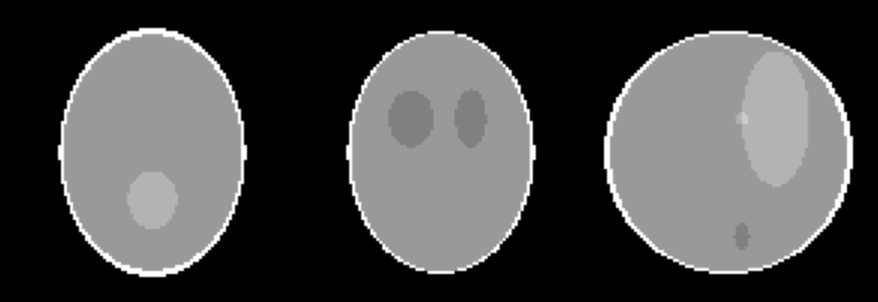

In [73]:
os=1.3
!riesling phantom --fov=192 --matrix=96 --shepp_logan --channels=4 \
  'phantom.h5' --nthreads=16 --os={os} --nex=0.2 --phyllo
plot_3plane('phantom-image.h5')

Now, the good news. Nearest-neighbour sampling does a very good job at estimating the SDC with the same oversampling as the reconstruction.

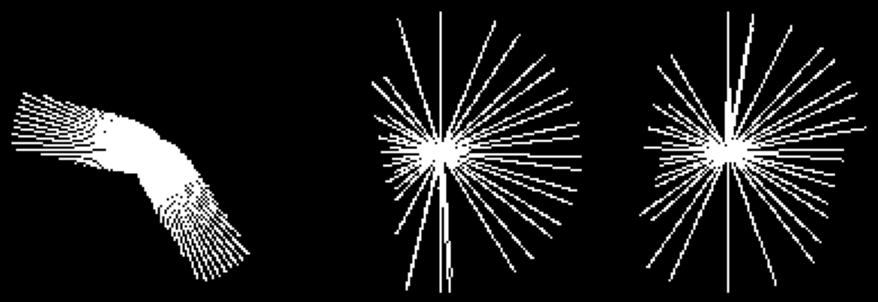

In [74]:
!riesling sdc 'phantom.h5' --os={os} --out=os13 --nthreads=16
!riesling traj 'phantom.h5' --os={os} --out=os13 --nthreads=16 --sdc=os13-sdc.h5
plot_3plane('os13-traj.h5', dset='image')

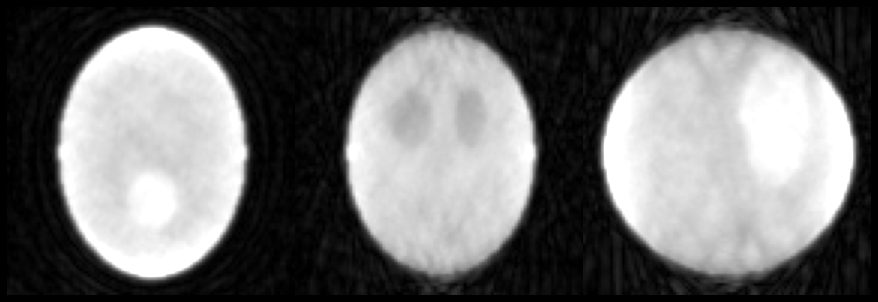

In [75]:
!riesling recon 'phantom.h5' --os={os} --out=os13 --nthreads=16
plot_3plane('os13-recon.h5')

And the other good news - we can take the SDC estimated with NN and use it in a reconstruction with a KB kernel, and it works well enough. This emphasises that the SDC only needs to be approximately correct to get a good result.

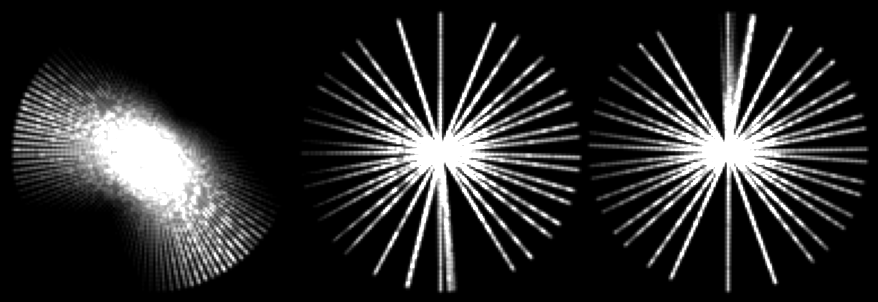

In [76]:

!riesling traj 'phantom.h5' --os={os} --kb --out=os13kb --nthreads=16 --sdc=os13-sdc.h5
plot_3plane('os13kb-traj.h5', dset='image')

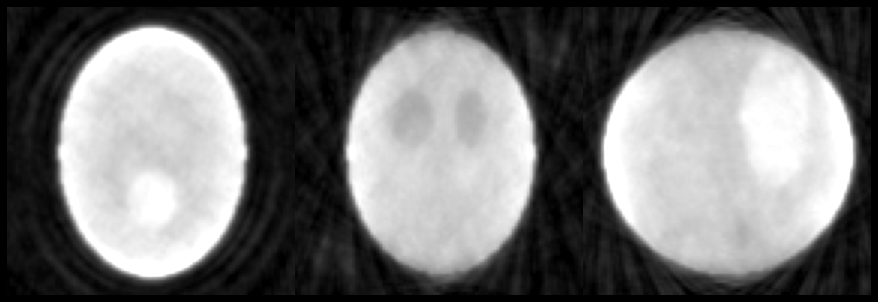

In [77]:
!riesling recon 'phantom.h5' --os={os} --kb --sdc=os13-sdc.h5 --out=os13kb  --nthreads=16
plot_3plane('os13kb-recon.h5')

Now for comparison, a reconstruction with a KB kernel and analytic weights. Note that high frequencies get over-emphasised, so edges are sharp but also visually more apparent noise.

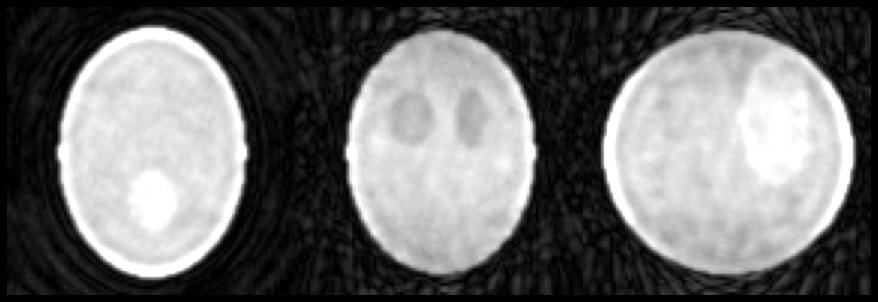

In [79]:
!riesling recon 'phantom.h5' --os={os} --kb --sdc=radial --out=radial --nthreads=16
plot_3plane('radial-recon.h5')

Now the other good news - the SDC method works when using the sqrt(KB) kernel (which is not optimal, the Zwart/Pipe kernel would be better), provided the oversampling is high enough during the `sdc` command

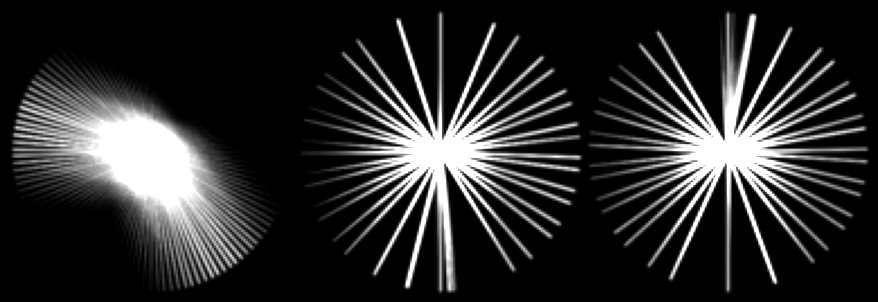

In [80]:
!riesling sdc 'phantom.h5' --os=3 --kb --out=os3kb --nthreads=16
!riesling traj 'phantom.h5' --os={os} --kb --out=os3kb --nthreads=16 --sdc=os3kb-sdc.h5
plot_3plane('os3kb-traj.h5', dset='image')

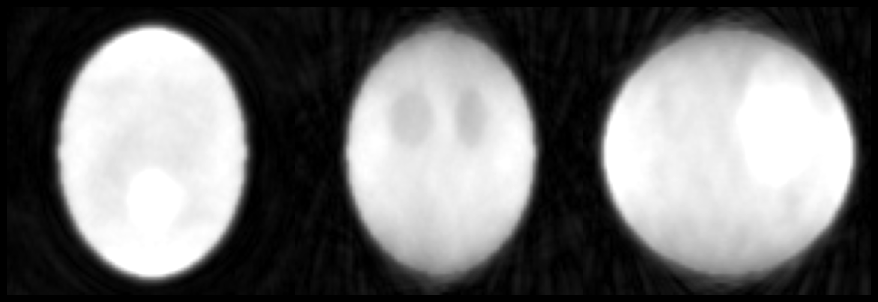

In [81]:
!riesling recon 'phantom.h5' --os={os} --kb --sdc=os3kb-sdc.h5 --out=os3kbkb --nthreads=16
plot_3plane('os3kbkb-recon.h5')

Finally, the bad news, or what caused this investigation in the first place. If we use a KB kernel and the same minimal oversampling as the reconstruction, the SDC goes wrong. Note that when showing the trajectory the very k-space center is still bright, and that importantly the ends of the spokes go weird.

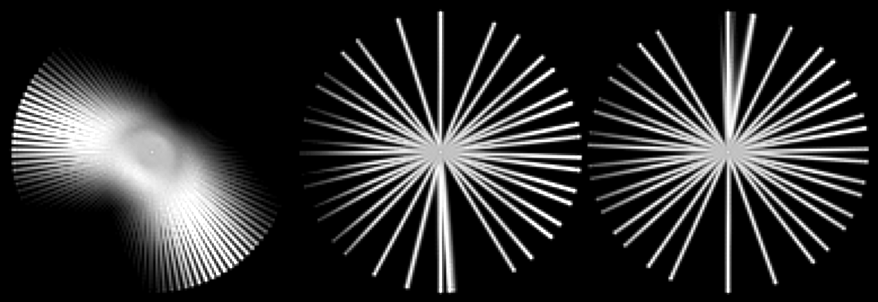

In [82]:
!riesling sdc 'phantom.h5' --os=1.3 --kb --out=os13kb --nthreads=16
!riesling traj 'phantom.h5' --os={os} --kb --out=os13kbkb --nthreads=16 --sdc=os13kb-sdc.h5
plot_3plane('os13kbkb-traj.h5', dset='image')

And that this leads to some nasty artefacts in the final reconstruction.

Correctly estimating the SDC with any of the above methods avoids this.

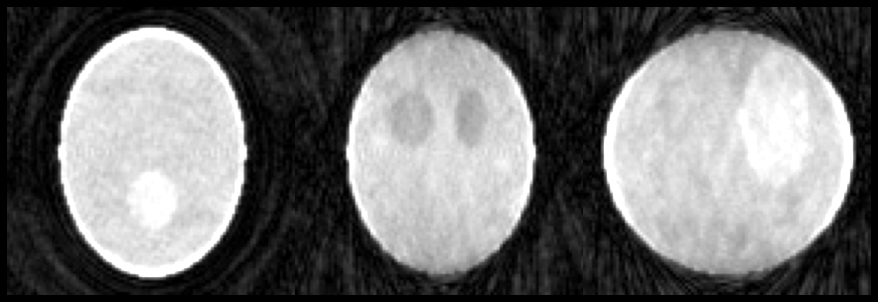

In [83]:
!riesling recon 'phantom.h5' --os={os} --kb --sdc=os13kb-sdc.h5 --out=os13kbkb --nthreads=16
plot_3plane('os13kbkb-recon.h5')